<h1 align="center">
Bảng phân công công việc
</h1>

|MSSV| Họ tên| Công việc|
|---|---|---|
|19120212| Vũ Công Duy| Mô hình hóa|
|19120297| Đoàn Việt Nam| Tiền xử lý dữ liệu và bonus point|
|19120328| Võ Trọng Phú| Khám phá dữ liệu|
|19120389| Tô Gia Thuận| Deploy mô hình|
|19120602| Hồ Hữu Ngọc| Tiền xử lý dữ liệu|

<hr>


In [1]:
!pip install vncorenlp

In [2]:
!pip install wordcloud

In [3]:
!pip install nltk

In [4]:
!pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
import vncorenlp
from vncorenlp import VnCoreNLP
import re
import seaborn as sns
import copy
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import wordcloud
from wordcloud import WordCloud
import nltk
from nltk import tokenize
import os
import tensorflow as tf
# tf.get_logger().setLevel('INFO')


2022-01-09 09:56:37.106375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 09:56:37.106389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Đọc data, stopwords, thư viện java

In [6]:
data=pd.read_csv("vn_news_223_tdlfr.csv")
f = open('resources/stopwords.txt', 'r', encoding='UTF-8')
stopwords = f.read().split('\n')
annotator = VnCoreNLP("resources/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')
data.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


# Tiền xử lý dữ liệu (Data preprocessing)
## 1. Xử lý noise
Các noise trong văn bản bao gồm các link, dấu xuống dòng, các kí tự đặc biệt, viết hoa sẽ được xử lý

In [7]:
def NoiseDefuse(s):
    result = copy.copy(s)
    result = result.str.lower()
    result = result.apply(lambda x: re.sub(r'http\S+', '', x))
    result = result.apply(lambda x: x.replace('\n',' '))
    result = result.apply(lambda x: re.sub('[^aàảãáạăằẳẵắặâầẩẫấậ b c dđeèẻẽéẹêềểễếệ f g hiìỉĩíịjklmnoòỏõóọôồổỗốộơờởỡớợpqrstu ùủũúụưừửữứựvwxyỳỷỹýỵz +[0-9]+', '', x))
    return result

## 2. TokenNize

In [8]:
#Giảm chiều dữ liệu
def reduce_dim(x):
    return x[0]

#Tách từ
def TokenNize(s):
    return s.apply(annotator.tokenize).apply(reduce_dim)


## 3.Normalize

In [9]:
#Hàm chuyển các từ viết tắt về dạng đầy đủ
def normalized1(x):
    contractions={
        ' cđv': ' cổ động viên',
        ' thcs': ' trung học cơ sở',
        ' pgs': ' phó giáo sư ',
        ' gs': ' giáo sư ',
        ' ts': ' tiến sĩ ',
        ' gd  đt': ' giáo dục - đào tạo',
        ' gd đt': ' giáo dục - đào tạo',
        ' gdđt': ' giáo dục - đào tạo',
        ' hlv': ' huấn luyện viên',
        ' tp': ' thành phố ',
        ' hcm': ' Hồ Chí Minh ',
        ' đt': ' đội tuyển ',
        ' gd': ' giáo dục '
    }
    for k,v in contractions.items():
        x=x.replace(k,v)
    return x
def normalized(s):
    return s.apply(normalized1)

## 4. Remove stopword

In [10]:
#Hàm loại bỏ các stopword
def remove_stopword(list_word):
    clean_list = []
    for i in range(len(list_word)):
        temp=list_word[i].replace('_',' ')
        if temp not in stopwords :
            clean_list.append(list_word[i])
    return clean_list


## 5. Tổng hợp

In [11]:
def Preprocess(s):
    a= TokenNize(normalized(NoiseDefuse(s)))
    a=a.apply(remove_stopword)
    return a
data['clean_text']= Preprocess(data['text'])
data

,text,domain,label,clean_text
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,"[thủ_tướng, abe, cúi, đầu, xin_lỗi, hành_động,..."
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,"[thủ_tướng, nhật, cúi, đầu, xin_lỗi, tinh_thần..."
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,"[choáng, cơ_trưởng, đeo, khăn_quàng, quẩy, ban..."
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,"[nhạc, kpop, hát, giáo_sư, nguyễn_lân, dũng, t..."
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,"[đại_học, hutech, áp_dụng, cải_cách, tiếq, việ..."
...,...,...,...,...
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0,"[siêu, máy_bay, a350, chở, cổ_động_viên, việt_..."
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,dantri.com.vn,0,"[thưởng, 20000, usd, đội_tuyển, cờ_vua, việt_n..."
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,dantri.com.vn,0,"[trường_sơn, giành, hcv, giải, cờ_vua, đồng_độ..."
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,dantri.com.vn,0,"[chàng, sinh_viên, luật, kiện_tướng, lê_tuấn, ..."


# Khám phá dữ liệu

## Dữ liệu có bị thiếu không ? Có cột nào sai kiểu dữ liệu không ? 

In [12]:
data.isnull().values.any()
#data.dropna()

False

Vậy là dữ liệu không có giá trị thiếu

In [13]:
data.dtypes

text          object
domain        object
label          int64
clean_text    object
dtype: object

Các cột dữ liệu đều có giá trị đúng

## Các text có kích thước như thế nào ?

### Mô tả kích thước

In [14]:
copy_data = data
copy_data['text_length'] = [len(a) for a in copy_data['text']]
copy_data['text_length'].describe()

count      223.000000
mean      2539.771300
std       1780.532008
min        309.000000
25%       1286.000000
50%       2009.000000
75%       3300.500000
max      10019.000000
Name: text_length, dtype: float64

### Kích thước trung bình của mỗi text

In [15]:
copy_data['text_length'].mean()

2539.7713004484303

## Mỗi miền báo có bao nhiêu bài viết ?

### Ta có thể in ra số lượng text của từng domain

In [16]:
domain_count = data.groupby(['domain'])['text'].count()
domain_count = domain_count.sort_values(ascending=False,)
domain_count

domain
vnexpress.net              73
tinvn.info                 68
dantri.com.vn              14
thethao.tuoitre.vn         10
thoibao.today               6
news.zing.vn                6
tuoitre.vn                  5
tintucqpvn.net              5
thanhnien.vn                5
kinhdoanh.vnexpress.net     3
phapluat.news               3
thegioitre.vn               2
giaitri.vnexpress.net       2
giadinhtiepthi.com          2
doisong.vnexpress.net       2
thoibao.de                  2
www.ipick.vn                2
www.gioitreviet.net         1
autoxe.net                  1
sohoa.vnexpress.net         1
suckhoe.vnexpress.net       1
sorry.vn                    1
baoangiang.com.vn           1
laodong.vn                  1
https://news.zing.vn        1
haiduong.tintuc.vn          1
dulich.vnexpress.net        1
binhluan.biz                1
baonuocmy.com               1
www.vietgiaitri.com/        1
Name: text, dtype: int64

### Miền báo có nhiều bài nhất

In [17]:
print("Miền báo có nhiều bài nhất:")
domain_count.idxmax()

Miền báo có nhiều bài nhất:


'vnexpress.net'

### Hmm, sử dụng biểu đồ bar chart để nhìn tổng quát hơn

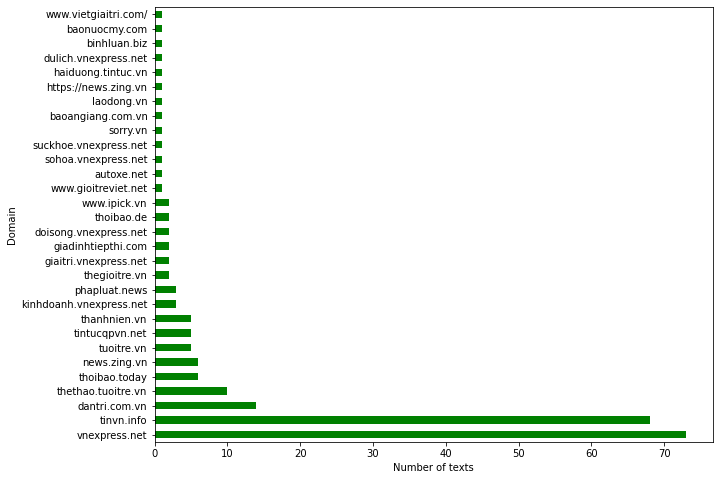

In [18]:
domain_count.plot(kind="barh", color = "green", figsize = (10,8))
plt.xlabel("Number of texts")
plt.ylabel("Domain")
plt.show()

## Tin giả và tin thật

### Ta có thể in ra số lượng tin giả ( ứng với 1) và tin thật ( ứng với 0)

In [19]:
label_count = data.groupby(['label'])['text'].count()
label_count

label
0    123
1    100
Name: text, dtype: int64

### Một vài biểu đồ 

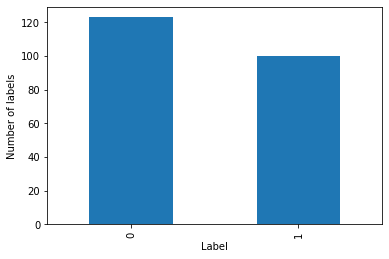

In [20]:
label_count.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Number of labels")
plt.show()

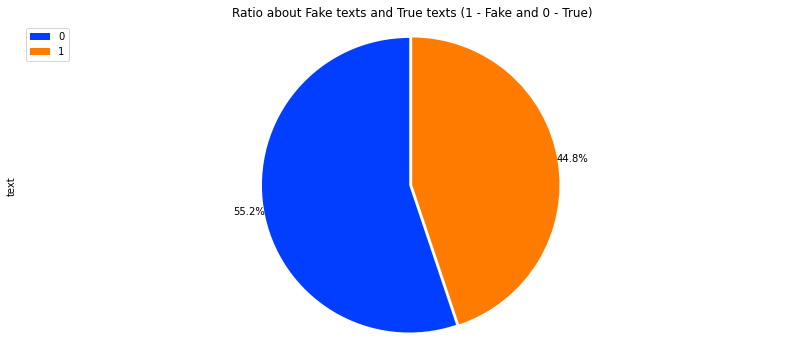

In [21]:
explode_list=[0,0.02]
label_count.plot(kind='pie',figsize=(14,6),autopct="%1.1f%%", startangle=90, labels=None, pctdistance=1.1
                            , explode=explode_list, colors = sns.color_palette('bright')[0:2])
plt.title("Ratio about Fake texts and True texts (1 - Fake and 0 - True)")
plt.axis('equal')
plt.legend(labels = label_count.index, loc='upper left');

Tuy có vẻ chênh lệch không nhiều nhưng tin thật vẫn có số lượng lớn hơn tin giả.

Mật độ của tin giả và tin thật khá đều nhau.

## Những từ khóa xuất hiện nhiều nhất 

### Đối với các tin thật (label = 0) thì những từ khóa nào xuất hiện nhiều nhất trong các bài viết ?

Mình sẽ lấy ra danh sách 20 từ được dùng nhiều nhất trong bộ tin thật

In [22]:
true_data = data[data["label"] == 0]
true_token_space = tokenize.WhitespaceTokenizer()
true_data_text = true_data['clean_text'].explode()
true_data_text = ' '.join(true_data_text)
true_token_phrase = true_token_space.tokenize(true_data_text)
true_count = nltk.FreqDist(true_token_phrase)
true_data_df = pd.DataFrame({"Word": list(true_count.keys()), "Number of words": list(true_count.values())})
true_data_df = true_data_df.nlargest(columns = "Number of words", n = 20)

In [23]:
true_data_df

,Word,Number of words
217,đi,270
294,thành_phố,214
39,xe,188
58,ảnh,181
30,đường,175
51,hai,144
295,Hồ_Chí_Minh,137
148,việt_nam,115
271,nam,106
101,2,98


Dùng bar chart để nhìn rõ nào

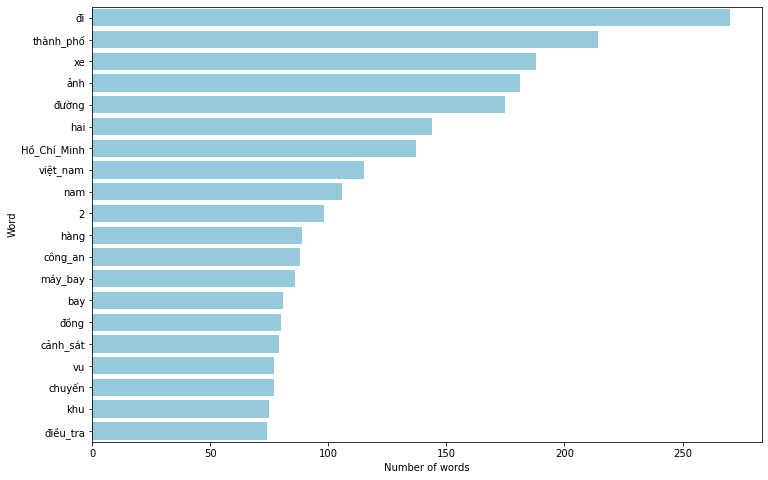

In [24]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = true_data_df, x = "Number of words", y = "Word", color = 'skyblue')
plt.show()

Từ "đi" được dùng nhiều nhất với hơn 250 lần (cụ thể là 270)

### Đối với các tin giả (label = 1) thì những từ khóa nào xuất hiện nhiều nhất trong các bài viết ?

Tương tự, Mình sẽ lấy ra danh sách 20 từ được dùng nhiều nhất trong bộ tin giả và vẽ biểu đồ tương ứng.

In [25]:
fake_data = data[data["label"] == 1]
fake_token_space = tokenize.WhitespaceTokenizer()
fake_data_text = fake_data['clean_text'].explode()
fake_data_text = ' '.join(fake_data_text)
fake_token_phrase = fake_token_space.tokenize(fake_data_text)
fake_count = nltk.FreqDist(fake_token_phrase)
fake_data_df = pd.DataFrame({"Word": list(fake_count.keys()), "Number of words": list(fake_count.values())})
fake_data_df = fake_data_df.nlargest(columns = "Number of words", n = 20)

In [26]:
fake_data_df

,Word,Number of words
69,đi,258
1796,chồng,147
648,mẹ,130
882,gái,116
433,ảnh,110
2230,vợ,104
89,1,95
2186,đức,93
227,mạng,90
73,thắng,75


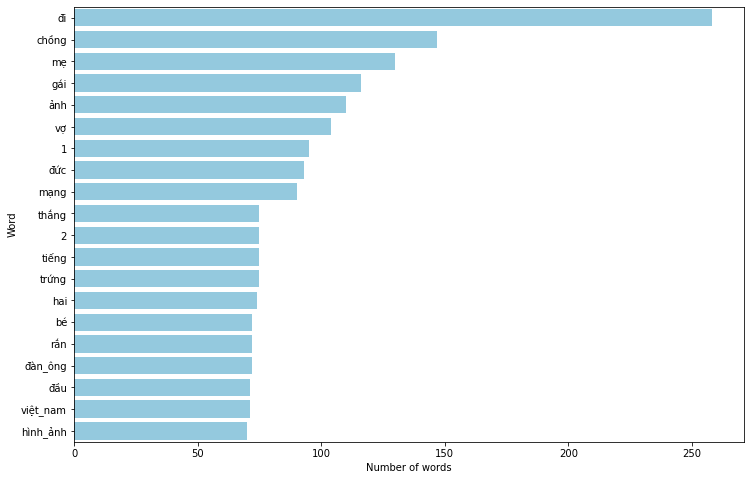

In [27]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = fake_data_df, x = "Number of words", y = "Word", color = 'skyblue')
plt.show()

Từ "đi" được dùng nhiều nhất với hơn 250 lần (cụ thể là 258)

Vậy là dù cho tin giả hay tin thật thì từ "đi" vẫn được dùng nhiều nhất

## Mô hình đám mây dữ liệu

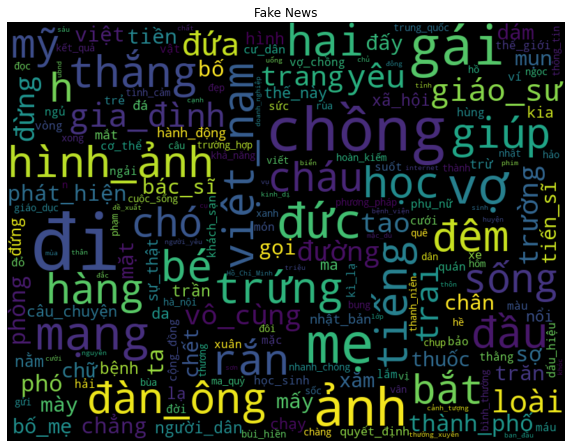

In [28]:
#fake news
fake_news = data[data['label']==1]
fake_news_text = fake_news['clean_text'].explode()
fake_news_text = ' '.join(fake_news_text)

wordcloud = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(fake_news_text)


plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Fake News')
plt.axis("off")
plt.savefig('image/fake_news_wordcloud.png', format='png')
plt.show();

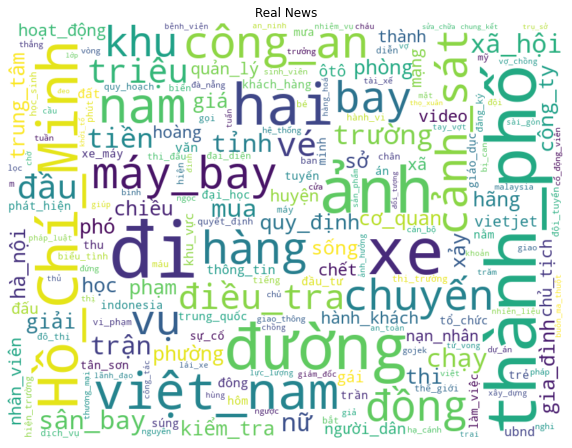

In [29]:
# real news
real_news = data[data['label']==0]
real_news_text = real_news['clean_text'].explode()
real_news_text = ' '.join(real_news_text)

wordcloud = WordCloud(width= 800, height= 600,
                          background_color='white',
                          max_font_size = 110,
                          collocations = False).generate(real_news_text)

plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Real News')
plt.axis("off")
plt.savefig('image/real_news_wordcloud.png')
plt.show();

# Xây dựng mô hình
Bọn em sẽ dùng phương thức CountVectorizer để vector hóa văn bản. Vì vậy, bọn em sẽ gộp token sau khi được làm sạch lại thành 1 văn bản để có thể sử dụng CountVectorizer().

## 1. Tiền xử lý cho mô hình

In [30]:
def fullPreprocess(s):
    return Preprocess(s).apply(lambda x:" ".join(x))

In [31]:
data['joined_clean_text'] = fullPreprocess(data['text'])
data.head()

,text,domain,label,clean_text,text_length,joined_clean_text
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,"[thủ_tướng, abe, cúi, đầu, xin_lỗi, hành_động,...",2244,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,"[thủ_tướng, nhật, cúi, đầu, xin_lỗi, tinh_thần...",884,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,"[choáng, cơ_trưởng, đeo, khăn_quàng, quẩy, ban...",1232,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,"[nhạc, kpop, hát, giáo_sư, nguyễn_lân, dũng, t...",3093,nhạc kpop hát giáo_sư nguyễn_lân dũng thành_đạ...
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,"[đại_học, hutech, áp_dụng, cải_cách, tiếq, việ...",8804,đại_học hutech áp_dụng cải_cách tiếq việt năm_...


## 2. Chia tập test và validation
Vì đây là mô hình dự đoán dựa trên text nên bọn em sẽ chỉ xét cột `'joined_clean_text'` tức cột text sau khi qua nhiều bước làm sạch và xử lý (bỏ qua cột `domain`) làm tập X và cột `'label'` làm tập y.  
Bọn em sẽ chia tập train và validation ra theo tỉ lệ 7/3.

In [32]:
X_train, X_val,y_train,y_val = train_test_split(data['joined_clean_text'],data['label'],random_state=212,test_size=0.3)

## 3. Cho chạy các mô hình

In [33]:
models = [LogisticRegression(),
sklearn.ensemble.RandomForestClassifier(),
#sklearn.naive_bayes.GaussianNB()
sklearn.svm.SVC()
]
acc_max = 0
accs = []
cm =[]
pipelines = []
for model in models:
    full_pipeline = make_pipeline(
    CountVectorizer(),
    model
    )
    pipelines.append(full_pipeline)
    full_pipeline.fit(X_train,y_train)
    y_pred = full_pipeline.predict(X_val)
    accs.append(accuracy_score(y_val,y_pred)*100)
    cm.append(confusion_matrix(y_val,y_pred,normalize='all'))

## 4. Nhận xét các mô hình

### Độ chính xác trên tập validation giữa các mô hình

                              val
model                            
LogisticRegression      89.552239
RandomForestClassifier  88.059701
SVC                     85.074627


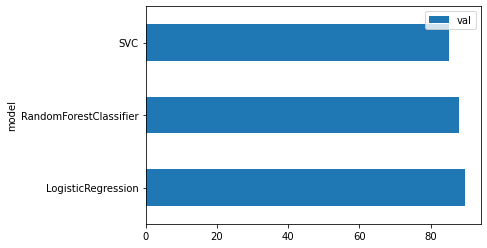

In [34]:
model_name = [type(x).__name__ for x in models]
plot_df = pd.DataFrame({'model':model_name,'val':accs}).set_index('model')
print(plot_df)
plot_df.plot.barh();

So sánh độ chính xác giữa các mô hình với nhau, ta thấy không có chênh lệch quá lớn. 

Nếu xét khoảng cách giữa mô hình có độ chính xác lớn nhất và thấp nhất thì vẫn có sự chênh lệch đáng xem xét.

Mô hình với độ chính xác cao nhất là : 

In [35]:
best_model = models[accs.index(max(accs))]
best_model, max(accs)

(LogisticRegression(), 89.55223880597015)

### Ma trận lỗi của các mô hình

Một tiêu chí để đánh giá mô hình phân lớp trong những bài toán như thế này là dùng ma trận lỗi.  

Ta sẽ quan tâm tới ô (0,1) - tỉ lệ fake news nhưng bị dự đoán là real news và ô (1,0) tỉ lệ real news bị dự đoán là fake news.  

Rõ ràng tỉ lệ fake news bị dự đoán là real news là tỉ lệ đáng được quan tâm hơn bởi khi thông tin giả được cho là thông tin thật thì sẽ được tiếp nhận vào gây ra sự nhẫm lần. Còn khi thông tin thật bị gắn là thông tin giả thì ta chỉ có thể bị thiếu thông tin (không biết còn đỡ biết biết những thứ sai).

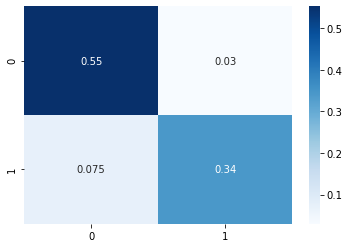

In [36]:
sns.heatmap(cm[0],annot=True,cmap='Blues');

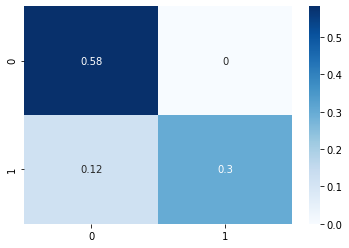

In [37]:
sns.heatmap(cm[1],annot=True,cmap='Blues');

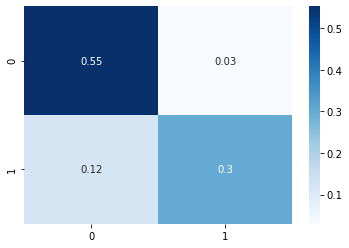

In [38]:
sns.heatmap(cm[2],annot=True,cmap='Blues');

Có thể thấy mô hình LogisticRegression cho ra kết quả khá tốt khi ô 0,1 chiếm tỉ lệ thấp nhất trong ba mô hình và đồng thời tổng tỉ lệ lỗi cũng là thấp nhất.

# Pipeline cho việc deploy mô hình + save mô hình
Tiến hành xây dựng pipe cho phần deploy.

Tiến hành huấn luyện các mô hình đã chọn trên tập dữ liệu đầy đủ (chứ không chia train và validation như trên) :

In [51]:
models_name = ['LogisticRegression','RandomForestClassifier', 'SVC']

for i in range(len(pipelines)):
    
    pipelines[i].fit(data['joined_clean_text'],data['label'])

    #save model
    with open('models_saved/' + models_name[i] + '.pkl','wb') as f:
        pickle.dump(pipelines[i],f)

Test thử các pipeline khi chạy trên chính tập huấn luyện (dù điều này khá vô nghĩa, nhưng cứ chạy thử)

In [40]:
for i in range(len(pipelines)):
    y_pred = pipelines[i].predict(fullPreprocess(data['text']))
    print(accuracy_score(y_pred,data['label']))

1.0
1.0
1.0


# Thử với một đoạn tin tức trước khi deploy
Test một bài báo lá cải có nội dung giật gân "nam thanh niên điển trai bỗng trở thành **người rắn** 😱. Với kết quả quá rõ ràng như vậy thì cả ba mô hình đều dự đoán là fake news theo kỳ vọng.

In [41]:
text_test = "Chỉ mới 3 tháng phát bệnh, nam thanh niên điển trai bỗng trở thành “người rắn” với làn da nứt toát đen xì. Hoàn cảnh nghèo túng lại mặc cảm vì bệnh tật, chàng trai 24 tuổi không chịu ăn uống nên thân hình càng gầy còm đáng sợ.\n \n Sinh ra trong hoàn cảnh nghèo khổ, mẹ bệnh tật nằm viện nhiều năm trời, chàng trai 24 tuổi với bao hoài bão lập nghiệp để có khả năng chữa bệnh cho mẹ. Vậy mà, tất cả đã sụp đổ khi Sáng bất ngờ bị căn bệnh kì lạ, quái ác.\n \n Hoàn cảnh đáng thương của chàng trai 24 tuổi mắc bệnh “người rắn” ở ấp Vinh Thanh, thị trấn Ngãi Giao, huyện Châu Đức, Bà Rịa Vũng Tàu khiến nhiều người xót xa.\n \n Từ chàng trai khỏe mạnh hoạt bát.\n \n Mới 3 tháng, Sáng đã ốm yếu, da dẻ nứt toát như da rắn.\n \n Cách đây 3 tháng, Sáng vẫn là một thanh niên điển trai, khỏe mạnh. Thế nhưng, Sáng bất ngờ phát hiện là da trở nên xanh xao lạ thường. Vốn tưởng mình mắc bệnh thiếu máu thông thường nên chủ quan, không ngờ dần dần cả cơ thể dần nứt toác, đen xì như da rắn.\n \n Cũng vì hoàn cảnh khó khăn, Sáng chỉ nằm viện vài ngày rồi ở nhà. Mặc cảm bệnh tật khiến chàng trai 24 tuổi hoạt bát ngày nào không dám tiếp xúc với người lạ, cũng không chịu ăn uống nên cơ thể ngày càng gầy còm. Xót xa hơn, chàng trai sợ căn bệnh của mình làm khổ gia đình nên đã buông tay, không còn ý chí chữa bệnh.\n \n \n –\n \n Gia cảnh quá khó khăn nên chàng trai 24 tuổi buông xuôi, không muốn tiếp tục chữa bệnh.\n \n Biết được số phận đáng thương của Sáng, nhiều nhà hảo tâm đã kêu gọi giúp đỡ và động viên em vượt qua căn bệnh hiểm nghèo.\n \n Ảnh: FB\n \n Nghi Ân (Tổng Hợp)\n \n http://vi.blogtamsu.video/thanh-nien-24-bong-hoa-nguoi-ran-sau-1-dem-da-de-nut-toac-den-xi-ai-nhin-cung-hai.html"
print("Nội dung bài báo :")
print(text_test[0:200]+"...")
print("Kết quả 3 mô hình dự đoán : ")
for pipeline in pipelines:
    print(pipeline.predict(fullPreprocess(pd.Series([text_test]))))

Nội dung bài báo :
Chỉ mới 3 tháng phát bệnh, nam thanh niên điển trai bỗng trở thành “người rắn” với làn da nứt toát đen xì. Hoàn cảnh nghèo túng lại mặc cảm vì bệnh tật, chàng trai 24 tuổi không chịu ăn uống nên thân ...
Kết quả 3 mô hình dự đoán : 
[1]
[1]
[1]


# Tiến hành deploy

Phần source code deploy sẽ nằm trong folder `deploy`, và link demo trên Internet nằm ở cuối file notebook này.

# Bonus point

### Tiền xử lý

In [42]:
Countfit=CountVectorizer().fit(X_train)
X_train1=Countfit.transform(X_train)
X_train1 = X_train1.toarray()
X_val1=Countfit.transform(X_val)
X_val1 = X_val1.toarray()

#### Khởi tạo model

In [43]:
model=tf.keras.models.Sequential()

2022-01-09 09:57:09.178059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 09:57:09.178346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 09:57:09.178390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-09 09:57:09.178424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-09 09:57:09.178456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

#### Thêm 4 lớp hidden với activation là "relu"

In [44]:
model.add(tf.keras.layers.Dense(10,input_shape=(X_train1.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dense(8,activation="relu"))
model.add(tf.keras.layers.Dense(6,activation="relu"))
model.add(tf.keras.layers.Dense(8,activation="relu"))

#### Thêm lớp output với 1 unit có hàm activation là "sigmoid" (sigmoid trả về xác suất từ 0->1)

In [45]:
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

#### Biên dịch mô hình

In [46]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#### Fit model (30 lần)

In [47]:
model.fit(X_train1, y_train, epochs=40)

Epoch 1/40
5/5 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5064
Epoch 2/40
5/5 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.7692
Epoch 3/40
5/5 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.9038
Epoch 4/40
5/5 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.9167
Epoch 5/40
5/5 [==============================] - 0s 1ms/step - loss: 0.5946 - accuracy: 0.9487
Epoch 6/40
5/5 [==============================] - 0s 2ms/step - loss: 0.5416 - accuracy: 0.9744
Epoch 7/40
5/5 [==============================] - 0s 2ms/step - loss: 0.4734 - accuracy: 0.9808
Epoch 8/40
5/5 [==============================] - 0s 1ms/step - loss: 0.3967 - accuracy: 0.9872
Epoch 9/40
5/5 [==============================] - 0s 2ms/step - loss: 0.3231 - accuracy: 0.9936
Epoch 10/40
5/5 [==============================] - 0s 1ms/step - loss: 0.2543 - accuracy: 0.9936
Epoch 11/40
5/5 [======================

#### Đánh giá mô hình

In [48]:
model.evaluate(X_val1,y_val,verbose=0)

[0.25063827633857727, 0.8805969953536987]

#### Dự đoán 

In [49]:
y_val_predict=model.predict(X_val1)
y_val_predict=y_val_predict[:,0]
y_val_predict=np.round(y_val_predict).astype('int')
y_val_predict

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1])

#### Độ chính xác

In [50]:
accuracy_score(y_val,y_val_predict)

0.8805970149253731

## Link deploy
Demo cho chương trình: [Link](https://share.streamlit.io/lokito01/demo-fakenewsdetection-ml/app.py)

## Nguồn tham khảo

https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

https://maelfabien.github.io/machinelearning/NLP_1/#i-what-is-preprocessing

https://github.com/SushwanthReddy/Fake-News-Detection-using-Machine-Learning/blob/master/FakeNewsDetection.ipynb?fbclid=IwAR1G2t9F6YJ3Wu6WPIpOX6GKV8oMF7PXRiUNqLHZzjhOP-uHw_wKORCmedg

https://www.kaggle.com/rodolfoluna/fake-news-detector?fbclid=IwAR31X9TZK68xc-G0nndQ8eF0YJXd0oRa-tj1levZvflUhm5V4cllmMBErmA

<hr>
